## やってみたいこと
単純なスタックオートエンコーダであれば、scikit-learnで実装できるのではないか？ という思い付き  
PCAとの精度比較も行う

---

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor #出力が連続値なのでRegressorを使う
from sklearn.decomposition import PCA
from sklearn.utils import check_random_state

print ("Numpy version:{0}".format(np.__version__))
print ("Scikit-Learn version:{0}".format(sklearn.__version__))

#minstデータをインポートし、trainとtestを分離
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05)

del X,y

Numpy version:1.19.2
Scikit-Learn version:0.23.2


In [2]:
#スケーラーを定義とX_trainの前処理
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

---

### `sklearn`によるスタックオートエンコーダ
`MLPRegressor`の`hidden_layer_sizes=`で中間層のエンコーダ・デコーダを定義する `fit`する際の`y`に`X_train`を指定することで、オートエンコーダとして機能するようになる  
('classifier'では出力がブール値になるため、連続値を出力する`Regressor`を使用する)

In [3]:
%%time
#スタックAE 784→100→30→100→784
mlp = MLPRegressor(
    hidden_layer_sizes=(100,30,100),
    verbose = True,
    early_stopping = True
)

#入出力にX_trainを指定することで、スタックオートエンコーダとして機能する
mlp.fit(X_train,X_train)

#推論する
X_dec_ae = scaler.inverse_transform(
    mlp.predict(
        scaler.transform(X_test)
    )
)

Iteration 1, loss = 0.02046431
Validation score: -202.173686
Iteration 2, loss = 0.01304316
Validation score: -80.554045
Iteration 3, loss = 0.01172393
Validation score: -89.506125
Iteration 4, loss = 0.01098939
Validation score: -28.893008
Iteration 5, loss = 0.01062775
Validation score: -32.514423
Iteration 6, loss = 0.01038768
Validation score: -50.067524
Iteration 7, loss = 0.01019774
Validation score: -23.254748
Iteration 8, loss = 0.01001659
Validation score: -22.403922
Iteration 9, loss = 0.00977314
Validation score: -21.321976
Iteration 10, loss = 0.00960126
Validation score: -14.184342
Iteration 11, loss = 0.00946384
Validation score: -13.105463
Iteration 12, loss = 0.00935741
Validation score: -11.124823
Iteration 13, loss = 0.00925756
Validation score: -12.504956
Iteration 14, loss = 0.00916511
Validation score: -12.295058
Iteration 15, loss = 0.00908007
Validation score: -12.219508
Iteration 16, loss = 0.00899765
Validation score: -6.625890
Iteration 17, loss = 0.00892557
V

---

### PCAとその逆変換による符号復号器
PCAインスタンスを`fit`で学習させたのち、`transform`-`inverse_transform`にて符号化→復号化を行う
`n_components`で残存分散率を指定できるため、AEよりもモデルチューニングが簡単で、かつ計算速度が極めて速い

In [4]:
%%time
#PCA
pca = PCA(n_components=0.999)
pca.fit(X_train)

#推論する
X_dec_pca = scaler.inverse_transform(
    pca.inverse_transform(
        pca.transform(
            scaler.transform(X_test)
            )
        )
    )

Wall time: 6.08 s


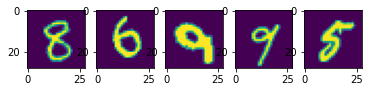

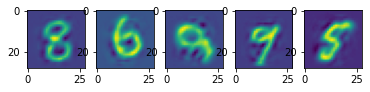

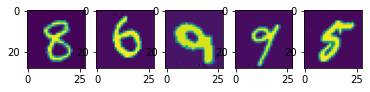

In [5]:
#元画像の可視化
for i in range (5):
    plt.subplot(int(151 + i))
    plt.imshow(X_test[i].reshape(28,28))
plt.show()

#オートエンコーダ復元画像の可視化
for i in range (5):
    plt.subplot(int(151 + i))
    plt.imshow(X_dec_ae[i].reshape(28,28))
plt.show()

#PCA復元画像の可視化
for i in range (5):
    plt.subplot(int(151 + i))
    plt.imshow(X_dec_pca[i].reshape(28,28))
plt.show()

思った以上にまともにオートエンコーダとして機能しているが、PCAはそれ以上に特徴量を正確に捉えている  
また計算時間はAEが2分強、PCAは10秒以下と、計算コストの面では全く比較にならない

---
## わかったこと
- 小規模かつ、複雑なモデルチューニングを行わないのなら`sklearn`でもスタックオートエンコーダは作れる
- が、得られる精度があまり良くなく、PCA次元削減→復元と比較すると精度も計算コストも大幅に劣る

復元誤差による判定を行うのなら、下手にAEのチューニングに走るよりもPCAを使ったほうがお手軽で高性能